## Set up

In [15]:
import pandas as pd
import os
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [2]:
# Define directories
def find_directory_upwards(dir_name):
    """
    Find the absolute path to a directory with the given name by searching upwards
    from the current notebook's directory.

    Parameters:
    dir_name (str): The name of the directory to find.

    Returns:
    str: The absolute path to the directory if found, otherwise None.
    """
    # Get the current notebook's directory
    current_dir = os.getcwd()
    
    while True:
        # Check if the directory exists in the current directory
        potential_path = os.path.join(current_dir, dir_name)
        if os.path.isdir(potential_path):
            return potential_path
        
        # Move to the parent directory
        parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
        
        # If the current directory is the root directory, stop searching
        if current_dir == parent_dir:
            break
        
        current_dir = parent_dir
    
    # If the directory is not found, return None
    return None

raw_data_dir = find_directory_upwards('raw_data')
outputs_dir = find_directory_upwards('outputs')
raw_data_dir

'c:\\Users\\juanb\\Documents\\HM_Treasury_Hackathon\\Nowcasting-GDP-UK\\data_processing\\raw_data'

## Load data

In [3]:
path = os.path.join(outputs_dir, 'df_tidy.csv')
df = pd.read_csv(path)
print(df.shape)
print(df.columns)
df.head(2)

(97, 124)
Index(['date', 'data_type', 'y', 'y_3', 'cpi_1', 'cpi_2', 'cpi_3', 'br_1',
       'br_2', 'br_3',
       ...
       'br_pc_2', 'unemply_pc_2', 'awe_pc_2', 'GBP/US_pc_2', 'GBP/EU_pc_2',
       'oil_pl_pc_2', 'us_gdp_pc_1', 'eu_gdp_pc_1', 'sr_pc_1', 'pop_pc_1'],
      dtype='object', length=124)


,date,data_type,y,y_3,cpi_1,cpi_2,cpi_3,br_1,br_2,br_3,...,br_pc_2,unemply_pc_2,awe_pc_2,GBP/US_pc_2,GBP/EU_pc_2,oil_pl_pc_2,us_gdp_pc_1,eu_gdp_pc_1,sr_pc_1,pop_pc_1
0,2000-09-01,train,0.2,0.5,72.508,72.876,72.771,6.0,6.0,6.0,...,0.102837,0.102837,0.102837,0.102837,0.102837,0.102837,0.000850,0.000850,0.000850,0.000850
1,2000-12-01,train,0.1,0.2,73.050,73.083,72.526,6.0,6.0,6.0,...,0.129716,0.129716,0.129716,0.129716,0.129716,0.129716,0.000968,0.000968,0.000968,0.000968


In [4]:
dict(df.isna().sum())

{'date': 0,
 'data_type': 0,
 'y': 0,
 'y_3': 0,
 'cpi_1': 0,
 'cpi_2': 0,
 'cpi_3': 0,
 'br_1': 0,
 'br_2': 0,
 'br_3': 0,
 'unemply_1': 0,
 'unemply_2': 0,
 'unemply_3': 0,
 'awe_1': 0,
 'awe_2': 0,
 'awe_3': 0,
 'GBP/US_1': 0,
 'GBP/US_2': 0,
 'GBP/US_3': 0,
 'GBP/EU_1': 0,
 'GBP/EU_2': 0,
 'GBP/EU_3': 0,
 'oil_pl_1': 0,
 'oil_pl_2': 0,
 'oil_pl_3': 0,
 'm4_1': 0,
 'm4_2': 0,
 'm4_lend_1': 0,
 'm4_lend_2': 0,
 'loans_1': 0,
 'loans_2': 0,
 'gscpi_1': 0,
 'gscpi_2': 0,
 'A_MoM_1': 0,
 'A_MoM_2': 0,
 'B_MoM_1': 0,
 'B_MoM_2': 0,
 'BE_MoM_1': 0,
 'BE_MoM_2': 0,
 'C_MoM_1': 0,
 'C_MoM_2': 0,
 'D_MoM_1': 0,
 'D_MoM_2': 0,
 'E_MoM_1': 0,
 'E_MoM_2': 0,
 'F_MoM_1': 0,
 'F_MoM_2': 0,
 'G_MoM_1': 0,
 'G_MoM_2': 0,
 'GT_MoM_1': 0,
 'GT_MoM_2': 0,
 'GVA_MoM_1': 0,
 'GVA_MoM_2': 0,
 'H_MoM_1': 0,
 'H_MoM_2': 0,
 'I_MoM_1': 0,
 'I_MoM_2': 0,
 'IOS_MoM_1': 0,
 'IOS_MoM_2': 0,
 'IOP_MoM_1': 0,
 'IOP_MoM_2': 0,
 'J_MoM_1': 0,
 'J_MoM_2': 0,
 'K_MoM_1': 0,
 'K_MoM_2': 0,
 'L_MoM_1': 0,
 'L_MoM_2': 0

In [5]:
X_colnames = [col for col in df.columns if col not in ['y', 'date', 'data_type']]
X_colnames

['y_3',
 'cpi_1',
 'cpi_2',
 'cpi_3',
 'br_1',
 'br_2',
 'br_3',
 'unemply_1',
 'unemply_2',
 'unemply_3',
 'awe_1',
 'awe_2',
 'awe_3',
 'GBP/US_1',
 'GBP/US_2',
 'GBP/US_3',
 'GBP/EU_1',
 'GBP/EU_2',
 'GBP/EU_3',
 'oil_pl_1',
 'oil_pl_2',
 'oil_pl_3',
 'm4_1',
 'm4_2',
 'm4_lend_1',
 'm4_lend_2',
 'loans_1',
 'loans_2',
 'gscpi_1',
 'gscpi_2',
 'A_MoM_1',
 'A_MoM_2',
 'B_MoM_1',
 'B_MoM_2',
 'BE_MoM_1',
 'BE_MoM_2',
 'C_MoM_1',
 'C_MoM_2',
 'D_MoM_1',
 'D_MoM_2',
 'E_MoM_1',
 'E_MoM_2',
 'F_MoM_1',
 'F_MoM_2',
 'G_MoM_1',
 'G_MoM_2',
 'GT_MoM_1',
 'GT_MoM_2',
 'GVA_MoM_1',
 'GVA_MoM_2',
 'H_MoM_1',
 'H_MoM_2',
 'I_MoM_1',
 'I_MoM_2',
 'IOS_MoM_1',
 'IOS_MoM_2',
 'IOP_MoM_1',
 'IOP_MoM_2',
 'J_MoM_1',
 'J_MoM_2',
 'K_MoM_1',
 'K_MoM_2',
 'L_MoM_1',
 'L_MoM_2',
 'M_MoM_1',
 'M_MoM_2',
 'O_MoM_1',
 'O_MoM_2',
 'N_MoM_1',
 'N_MoM_2',
 'P_MoM_1',
 'P_MoM_2',
 'Q_MoM_1',
 'Q_MoM_2',
 'R_MoM_1',
 'R_MoM_2',
 'S_MoM_1',
 'S_MoM_2',
 'T_MoM_1',
 'T_MoM_2',
 'us_gdp_2',
 'us_gdp_5',
 'eu_gdp_2

In [6]:
import feature_selection

train_data_mask = df['data_type']=='train'
selected_vars = feature_selection.fit_lasso_time_series(df[train_data_mask], 'y', X_colnames)


In [7]:
print(len(selected_vars))
selected_vars

45


['y_3',
 'GBP/US_1',
 'gscpi_1',
 'B_MoM_1',
 'D_MoM_1',
 'D_MoM_2',
 'G_MoM_1',
 'GVA_MoM_1',
 'GVA_MoM_2',
 'H_MoM_2',
 'I_MoM_1',
 'I_MoM_2',
 'IOS_MoM_2',
 'J_MoM_2',
 'K_MoM_2',
 'L_MoM_1',
 'M_MoM_1',
 'N_MoM_1',
 'N_MoM_2',
 'P_MoM_1',
 'P_MoM_2',
 'Q_MoM_1',
 'R_MoM_1',
 'R_MoM_2',
 'S_MoM_1',
 'T_MoM_2',
 'pop_2',
 'A_QoQ_2',
 'F_QoQ_2',
 'GT_QoQ_2',
 'P3G_QoQ_2',
 'P3H_QoQ_2',
 'P3N_QoQ_2',
 'P51_QoQ_2',
 'P51S_QoQ_2',
 'P6_QoQ_2',
 'cpi_pc_1',
 'br_pc_1',
 'cpi_pc_2',
 'br_pc_2',
 'unemply_pc_2',
 'us_gdp_pc_1',
 'eu_gdp_pc_1',
 'sr_pc_1',
 'pop_pc_1']

In [8]:
# Divide data into training and testing sets
train = df[train_data_mask]
test = df[~train_data_mask]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[selected_vars])
X_test = scaler.transform(test[selected_vars])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test[selected_vars])

# Get y_train and y_test
y_train = train['y']
y_test = test['y']

c:\Python39\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
# Define the model

# model = XGBRegressor(random_state=42)
model = RandomForestRegressor(max_depth=2, random_state=0)
# model = SVR()
# model = LinearRegression()

In [10]:
# Fit the model
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [11]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred

array([ 0.27217233,  0.00653826,  0.95689629, -0.21208928,  1.08996923,
        0.29868534,  0.21300124])

In [12]:
y_pred

array([ 0.27217233,  0.00653826,  0.95689629, -0.21208928,  1.08996923,
        0.29868534,  0.21300124])

In [13]:
y_test

90    0.0
91    0.1
92   -0.1
93   -0.6
94    0.4
95    0.3
96   -0.1
Name: y, dtype: float64

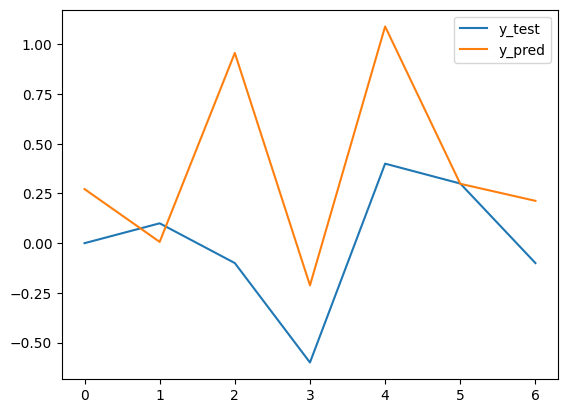

In [16]:
# Plot y_test and y_pred against date
import matplotlib.pyplot as plt
plt.plot(np.array(y_test),  label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [17]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

MAE: 0.4021037453841792
RMSE: 0.5243153935122155


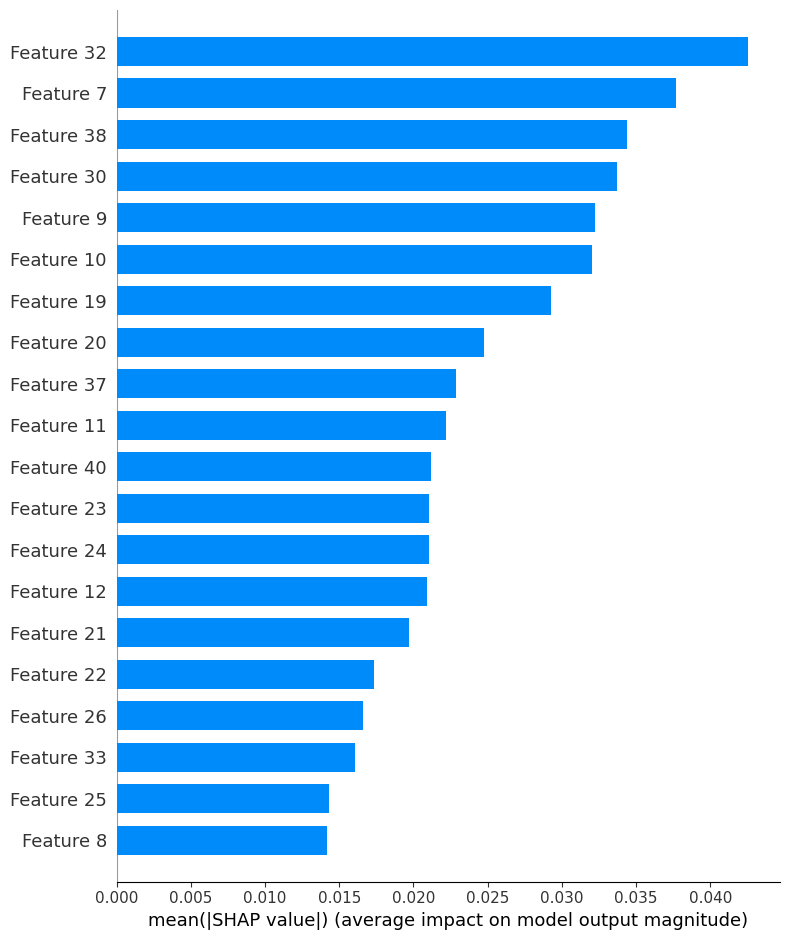

In [27]:
# Convert the scaled training data back to a DataFrame with the correct column names.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_vars)

# Create the SHAP explainer using your model.
explainer = shap.TreeExplainer(model)

# Calculate SHAP values on the scaled training data.
shap_values = explainer(X_train_scaled)

# Use the DataFrame (with feature names) for the summary plot.
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar")
plt.show()


In [ ]:
model.

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names_in_'